## Linear regressor with iterative optimization: SGDRegressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
np.random.seed(306)

In [3]:
shupple_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [5]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, 
                                                                                    labels, random_state=42)

In [6]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

### Baseline SGDRegressor
* **STEP1:** To begin with, instantiate a baseline SGDRegressor mode with default parameters
* **STEP2:** Train the model with training featur matrix and labels.
* **STEP3:** obtain score on the training and devel data.

In [13]:
sgd = SGDRegressor(random_state=42)
print(train_labels.shape)

sgd.fit(train_features, train_labels)
train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)


(11610,)
Mean absolute error on Training set: 327898229800533.75
Mean absolute error on development set: 331110341291405.44


## Adding a feature scalling step
SGD is sensitive on feature scaling. Let's add a feature scaling step and check if we get batter MAE

In [14]:
sgd_pipeline = Pipeline([
  ('features_scaling', StandardScaler()),
  ('sgd', SGDRegressor())
])
sgd_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('features_scaling', StandardScaler()),
                ('sgd', SGDRegressor())])

In [23]:
std_scaler = StandardScaler()

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
test_mae = mean_absolute_error(test_labels, sgd_pipeline.predict(test_features))
print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', test_mae)

Mean absolute error on Training set: 0.7120658904697413
Mean absolute error on development set: 0.7046481590829589


## Step-Wise training of SGDRegressor
* **STEP 1**: Instantiate SGDRegressor with warm_start=True and tol=-np.infty.
* **STEP 2**: Train SGD step by step and record regression loss in eaxh step.
* **STEP 3**: plot learning curves and see if there are any issues in training.

/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

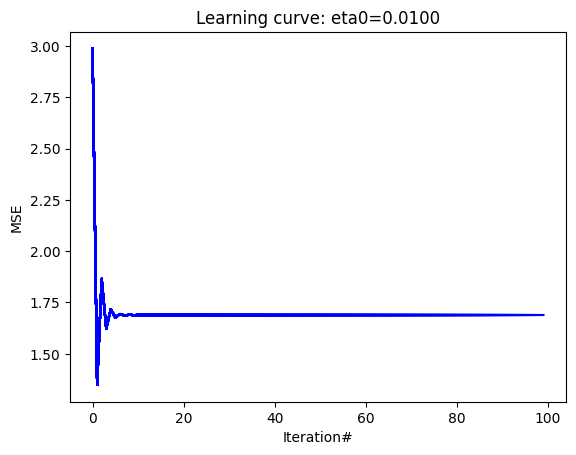

In [32]:
eta0 = 1e-2
tol = 10000000
sgd_pipeline = Pipeline([
  ("feature_scaling", StandardScaler()),
  ("SGD", SGDRegressor(max_iter=1, tol= tol,
                       warm_start=True,
                       random_state=42))
])

loss= []
for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels,
                                  sgd_pipeline.predict(train_features)))
  plt.plot(np.arange(len(loss)), loss, 'b-')
  plt.xlabel('Iteration#')
  plt.ylabel('MSE')
  plt.title(f'Learning curve: eta0={eta0:.4f}')

the loss reduced initialy and then increased. this could be due to large learning rates. we will reduce the learning rate by a factor of 10 and retry.

In [40]:
import sklearn
print(sklearn.__version__)

1.2.2


/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

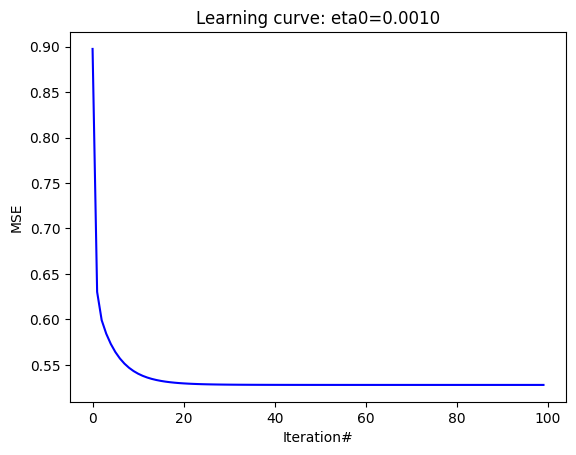

In [42]:
eta0 = 1e-3
sgd_pipeline_2 = Pipeline([
  ('feature_scaling', StandardScaler()),
  ('SGD', SGDRegressor(max_iter=1, tol= tol,
                       warm_start= True, eta0= eta0,
                       random_state= 42))
])

loss = []
for epoch in range(100):
  sgd_pipeline_2.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels, sgd_pipeline_2.predict(train_features)))


plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')



## Fixing learning rate through validation curves
* **STEP 1:** provide the list of values to be tried for a hyper-parameter.
* **STEP 2:** Instantiate an object of validation_curve with estimator, training features and labels. Set scroing paratmeter to relevant scores.
* **STEP 3:** Convert scores to error
* **STEP 4:** Plot validation curve with the value of hyper-parameter on x-axis and error on the y-axis
* **STEP 5:** Fix the hyper-parameter value where the test error is the least.

In [46]:
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(sgd_pipeline, com_train_features, 
                                             com_train_labels, cv= shupple_split_cv, 
                                             param_name='SGD__eta0', param_range= eta0,
                                             scoring='neg_mean_squared_error', n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores



/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/anni/BS/jupyterLab/jupitor_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

Text(0.5, 1.0, 'validation_curve for SGH')

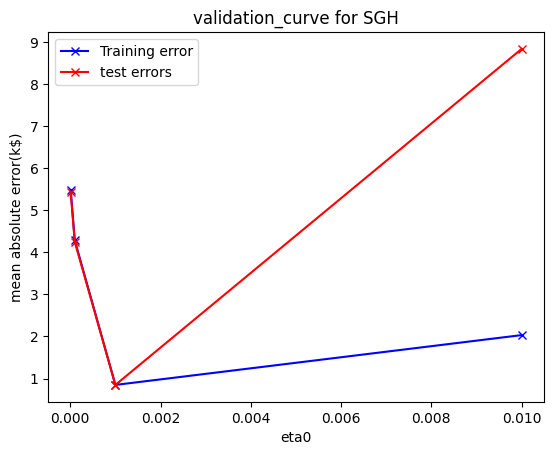

In [47]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label='Training error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label="test errors")
plt.legend()

plt.xlabel('eta0')
plt.ylabel('mean absolute error(k$)')
plt.title('validation_curve for SGH')


we also plot standard deviation in erros

Text(0.5, 1.0, 'Validation curve of SGD')

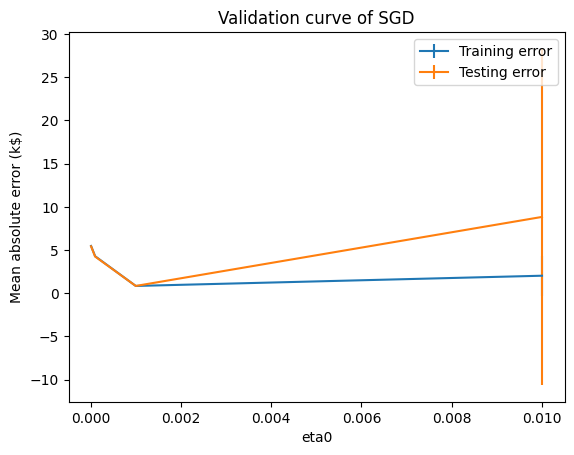

In [48]:
plt.errorbar(eta0, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')

plt.errorbar(eta0, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')

plt.legend()

plt.xlabel('eta0')
plt.ylabel('Mean absolute error (k$)')
plt.title('Validation curve of SGD')

## SGD Regressor one more example

In [50]:
sgd_pipeline_3 = Pipeline([
  ('features_scaling', StandardScaler()),
  ('sgd', SGDRegressor(max_iter=500,
                       early_stopping=True, 
                       eta0=1e-3,
                       tol=1e-3,
                       validation_fraction=0.2,
                       n_iter_no_change=5,
                       average=10,
                       random_state=42))
])
sgd_pipeline_3.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline_3.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline_3.predict(dev_features))

print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)


Mean absolute error on Training set: 0.5433287489797833
Mean absolute error on development set: 0.5345612073911921


In [51]:
print('Number of SGD itreations:', sgd_pipeline_3[-1].n_iter_)
print('number of weight updates:', sgd_pipeline_3[-1].t_)

Number of SGD itreations: 35
number of weight updates: 406351.0


In [54]:
sgd_pipeline_contant_learning = Pipeline([
  ('features_scaling', StandardScaler()),
  ('sgd', SGDRegressor(max_iter= 500,
                       early_stopping=True,
                       eta0= 1e-3,
                       tol= 1e-3,
                       learning_rate='constant',
                       validation_fraction= 0.2,
                       n_iter_no_change= 5,
                       average= 10,
                       random_state= 42))
])

sgd_pipeline_contant_learning.fit(train_features, train_labels)
train_mae = mean_absolute_error(train_labels, sgd_pipeline_contant_learning.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline_contant_learning.predict(dev_features))

print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)
print('Number of SGD itreations:', sgd_pipeline_contant_learning[-1].n_iter_)
print('number of weight updates:', sgd_pipeline_contant_learning[-1].t_)

Mean absolute error on Training set: 0.5528203432984674
Mean absolute error on development set: 0.5689568216133667
Number of SGD itreations: 11
number of weight updates: 127711.0


### Adaptive learning rate

In [56]:
sgd_pipeline_adaptive = Pipeline([
  ('features_scaling', StandardScaler()),
  ('sgd', SGDRegressor(max_iter=500,
                       early_stopping=True,
                       eta0=1e-3,
                       tol=1e-3,
                       learning_rate='adaptive', 
                       validation_fraction=0.2,
                       n_iter_no_change=5,
                       average= 10,
                       random_state=42))
])

sgd_pipeline_adaptive.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline_adaptive.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline_adaptive.predict(dev_features))

print('Mean absolute error on Training set:', train_mae)
print('Mean absolute error on development set:', dev_mae)
print('Number of SGD itreations:', sgd_pipeline_adaptive[-1].n_iter_)
print('number of weight updates:', sgd_pipeline_adaptive[-1].t_)

Mean absolute error on Training set: 0.5375525445454805
Mean absolute error on development set: 0.5200254740759911
Number of SGD itreations: 40
number of weight updates: 464401.0
